In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import pyplot
from scipy.stats import norm
import datetime as dt
from datetime import date, timedelta

In [13]:
# Import data
N_gas = pd.read_csv("Nat_gas.csv")

In [14]:
N_gas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [15]:
N_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


In [16]:
#changing the date to datetime format
N_gas['Dates'] = pd.to_datetime(N_gas['Dates'])

In [17]:
N_gas.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [18]:
N_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


In [20]:
N_gas.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [42]:
prices = N_gas['Prices'].values
dates = N_gas['Dates'].values


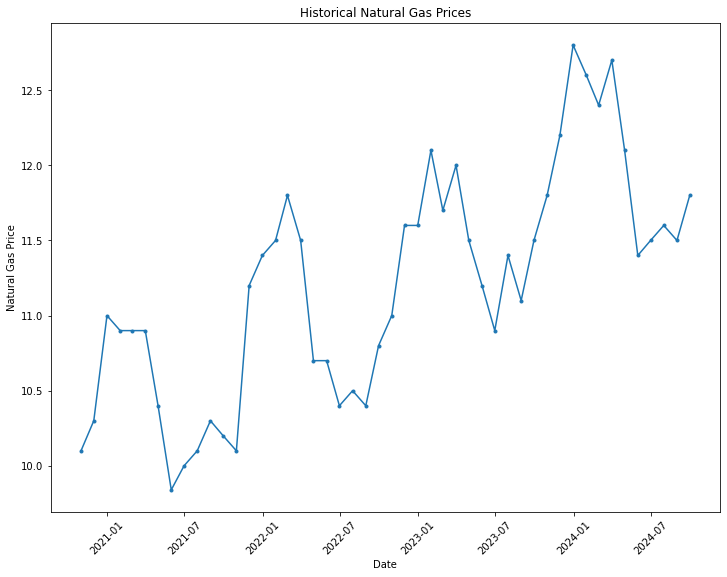

In [21]:
plt.figure(figsize=(12, 9))
plt.plot(N_gas['Dates'], N_gas['Prices'], marker='.')
plt.xlabel('Date')
plt.ylabel('Natural Gas Price')
plt.title('Historical Natural Gas Prices')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

In [32]:
#creating a price estimatimation function 
def estimate_price(date):
    # Convert the input date to datetime
    date = pd.to_datetime(date)

    # Extract the month and day from the input date
    month = date.month
    day = date.day

    # Filter the data to include only the relevant month and next year
    relevant_data = N_gas[(N_gas['Dates'].dt.month == month) & (N_gas['Dates'].dt.year <= date.year + 1)]

    # Linear interpolation
    price_estimate = np.interp(day, relevant_data['Dates'].dt.day, relevant_data['Prices'])

    return price_estimate

In [33]:
# Test the estimate_price function
input_date = '2025-05-15'
estimated_price = estimate_price(input_date)
print(f"Estimated Natural Gas Price on {input_date}: {estimated_price:.2f}")

Estimated Natural Gas Price on 2025-05-15: 9.84


In [35]:
# Test the estimate_price function
input_date = '2025-06-15'
estimated_price = estimate_price(input_date)
print(f"Estimated Natural Gas Price on {input_date}: {estimated_price:.2f}")


Estimated Natural Gas Price on 2025-06-15: 10.00


In [37]:
#Getting the dates in terms of day
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]


In [39]:
#Getting a simple regression, slope,intercept for the data
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept



In [43]:
time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)


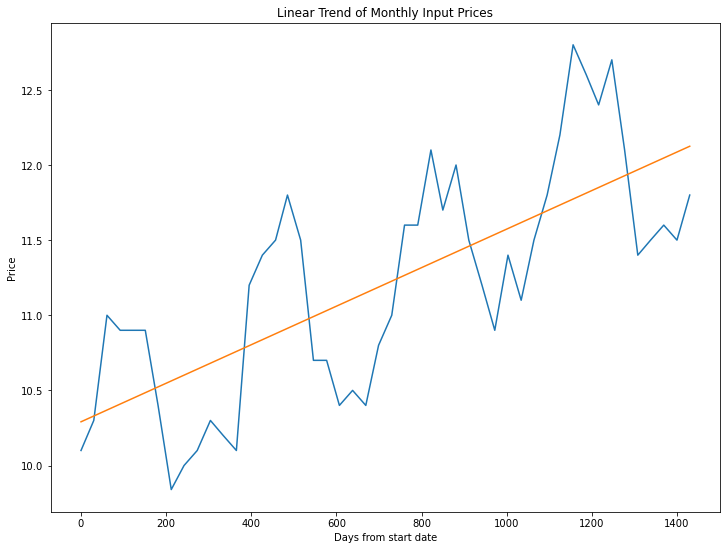

0.001282373598760221 10.29104112595228


In [46]:
#plotting the linear trend
plt.figure(figsize=(12, 9))
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)

In [47]:
#using bilinear regression to account for the seasonal component of natural gas usage. this because of the assumption that natural gas 
#is used more in the winter than in the summer.  
sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)


In [48]:
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)


Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

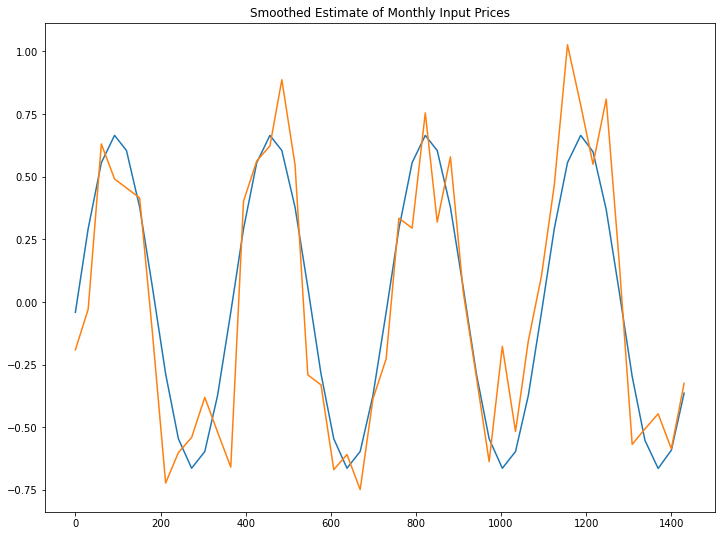

In [50]:
plt.figure(figsize=(12, 9))
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')


# TASK 2

for this task we are to create a price contact function that calculate the profit or loss for undertaking a contract of buying, storing and selling of natural gas.

To create this function we have eight inputs
- in_date
- in_prices
- out_date
- out_prices
- rate
- storage_cost_rate
- total_volume
- injection_withdrawal_cost_rate

In [51]:
import math


In [126]:
def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    volume = 0
    buy_cost = 0
    cash_in = 0
    last_date = min(min(in_dates), min(out_dates))
    
    # Ensuring that the dates are in sequence
    all_dates = sorted(set(in_dates + out_dates))
    
    for i in range(len(all_dates)):
        # processing code for each date
        start_date = all_dates[i]
# Cost to purchase gas
        if start_date in in_dates:
            # Inject on these dates and sum up cash flows
            if volume <= total_vol - rate:
                volume += rate
                buy_cost += rate * in_prices[in_dates.index(start_date)]
                # Injection cost
                injection_cost = rate * injection_withdrawal_cost_rate
                buy_cost += injection_cost
                print('Injected gas on %s at a price of %s'%(start_date, in_prices[in_dates.index(start_date)]))
# We do not want to inject when rate is greater than total volume minus volume
            else:
             print('Injection is not possible on date %s as there is insufficient space in the storage facility'%start_date)
        if start_date in out_dates:
            #Withdraw on these dates and sum cash flows
            if volume >= rate:
                volume -= rate
                cash_in += rate * out_prices[out_dates.index(start_date)]
                # Withdrawal cost
                withdrawal_cost = rate * injection_withdrawal_cost_rate
                cash_in -= withdrawal_cost
                print('Extracted gas on %s at a price of %s'%(start_date, out_prices[out_dates.index(start_date)]))
            else:
                # we cannot withdraw more gas than is actually stored
                print('Extraction is not possible on date %s as there is insufficient volume of gas stored'%start_date)
    store_cost = math.ceil((max(out_dates) - min(in_dates)).days // 30) * storage_cost_rate
    return cash_in - store_cost - buy_cost

In [127]:
#testing the function
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)] 
in_prices = [20, 21, 20.5, 22]
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)] 
out_prices = [23, 19, 21, 25] # prices on the extraction days
rate = 100000  # rate of gas in cubic feet per day
storage_cost_rate = 10000  # total volume in cubic feet
injection_withdrawal_cost_rate = 0.0005  # $/cf
max_storage_volume = 500000 # maximum storage capacity of the storage facility
result = price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, max_storage_volume, injection_withdrawal_cost_rate)
print()
print(f"The value of the contract is: ${result}")


Injected gas on 2022-01-01 at a price of 20
Extracted gas on 2022-01-27 at a price of 23
Injected gas on 2022-02-01 at a price of 21
Extracted gas on 2022-02-15 at a price of 19
Injected gas on 2022-02-21 at a price of 20.5
Extracted gas on 2022-03-20 at a price of 21
Injected gas on 2022-04-01 at a price of 22
Extracted gas on 2022-06-01 at a price of 25

The value of the contract is: $399600.0


# TASK 3

For this task we are to a model that predicts the probaility that a borrower will defult on thier loan.
using three different models 
- Logistic Regression 
- Simple Linear Regression 
- Decision Tree 

we can create a model that perdicts the probaility of default

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics


In [130]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [136]:
#spliting the data into features(x) and target(y)
X= df.drop(['customer_id','default'], axis=1)
y= df['default']

In [137]:
#Calculate the payment_to_income ratio
df['payment_to_income'] = df['loan_amt_outstanding'] / df['income']
    
# Calculate the debt_to_income ratio
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']


In [138]:
#Split the data into training and testing sets
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=0)

#standardize the features
scaler=          StandardScaler()
X_train_scaled =  scaler.fit_transform(X_train)
X_test_scaled =   scaler.transform(X_test)

#training model
logreg_model= LogisticRegression()
logreg_model.fit(X_train_scaled, y_train)

lrreg_model= LinearRegression()
lrreg_model.fit(X_train_scaled, y_train)

dtc_model= DecisionTreeClassifier()
dtc_model.fit(X_train_scaled, y_train)

#using the trained model to predict whether loan defult  

logreg_model_pred=  logreg_model.predict(X_test_scaled)
lrreg_model_pred=   (lrreg_model.predict(X_test_scaled)>=0.5).astype(int)# converts prediction into binary values
dtc_model_pred=     dtc_model.predict(X_test_scaled)

#evaluating model accuracy

logreg_model_accuracy= accuracy_score(y_test,logreg_model_pred)
lrreg_model_accuracy=  accuracy_score(y_test,lrreg_model_pred)
dtc_model_accuracy=    accuracy_score(y_test,dtc_model_pred)

logreg_model_confusion_matrix= confusion_matrix(y_test,logreg_model_pred)
lrreg_model_confusion_matrix = confusion_matrix(y_test,lrreg_model_pred)
dtc_model_confusion_matrix =    confusion_matrix(y_test, dtc_model_pred)

print("Logistic Regression Accuracy:", logreg_model_accuracy)
print("Simple Linear Regression Accuracy:", lrreg_model_accuracy)
print("Decision Tree Accuracy:", dtc_model_accuracy)

print("Logistic Regression Confusion Matrix:\n", logreg_model_confusion_matrix)
print("Simple Linear Regression Confusion Matrix:\n", lrreg_model_confusion_matrix)
print("Decision Tree Confusion Matrix:\n", dtc_model_confusion_matrix)


Logistic Regression Accuracy: 0.997
Simple Linear Regression Accuracy: 0.985
Decision Tree Accuracy: 0.986
Logistic Regression Confusion Matrix:
 [[1640    1]
 [   5  354]]
Simple Linear Regression Confusion Matrix:
 [[1612   29]
 [   1  358]]
Decision Tree Confusion Matrix:
 [[1627   14]
 [  14  345]]


From the results we can see that logistic regresion has the highest accuracy at 99.7% with a relative low false negatives and positive values comparied to other models.

# TASK 4

For this task we are to bucket customers with various FICO scores in order to narrow in on the probability of default. We are using 2 methods the MSE and the log likelihood.

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

#predict default probalities on the test set
default_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Get FICO scores from the test set
fico_scores = X_test['fico_score']

#calculate mean squared error for different bucket boundaries
mse_values=[]
num_buckets =5 

for i in range(1, num_buckets):
        bucket_boundaries = np.percentile(fico_scores, np.linspace(0, 100, i + 1))
        bucket_predictions = [default_prob[(fico_scores >= bucket_boundaries[j]) & (fico_scores <= bucket_boundaries[j + 1])].mean() for j in range(i)]
        mse = mean_squared_error(bucket_predictions, y_test[:len(bucket_predictions)])  # Ensure lengths match
        mse_values.append((i, mse))
        
#find optimal number of buckets with minimum MSE  
optimal_num_buckets= min(mse_values, key=lambda x: x[1])[0]
print("Optimal Number of Buckets:", optimal_num_buckets)

# Calculate bucket boundaries based on the optimal number of buckets

optimal_bucket_boundaries = np.percentile(fico_scores, np.linspace(0, 100, optimal_num_buckets + 1))
print("Optimal Bucket Boundaries:", optimal_bucket_boundaries)

# Calculate log-likelihood values for different bucket boundaries
log_likelihood_values = []
num_buckets = 10  

for i in range(1, num_buckets):
    bucket_boundaries = np.percentile(fico_scores, np.linspace(0, 100, i + 1))
    bucket_indices = np.digitize(fico_scores, bucket_boundaries) - 1

    bucket_probabilities = [default_prob[bucket_indices == j].mean() for j in range(i)]
    bucket_defaults = [y_test[bucket_indices == j].sum() for j in range(i)]
    bucket_total = [len(y_test[bucket_indices == j]) for j in range(i)]
    bucket_likelihood = sum([(default * np.log(prob) + (total - default) * np.log(1 - prob)) for default, prob, total in zip(bucket_defaults, bucket_probabilities, bucket_total)])

    log_likelihood_values.append((i, bucket_likelihood))
    
# Find the optimal number of buckets with maximum log-likelihood
optimal_num_buckets = max(log_likelihood_values, key=lambda x: x[1])[0]
print("Optimal Number of Buckets (Log-Likelihood):", optimal_num_buckets)

# Calculate bucket boundaries based on the optimal number of buckets
optimal_bucket_boundaries = np.percentile(fico_scores, np.linspace(0, 100, optimal_num_buckets + 1))


print("Optimal Bucket Boundaries (Log-Likelihood):", optimal_bucket_boundaries)

From our results the MSE condenses the dataset into one bucket while, log likelihood prodvides a more robust look at the dataset.